In [13]:
import numpy as np
import copy
import pandas as pd
import sys
sys.path.insert(0,'../')
from gym_ur.game_of_ur import GoUrEnv
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.cm as cm
import dill
import os.path
plt.style.use('ggplot')

In [14]:
def eGreedyActionSelection(env, q_curr, eps, possible_actions, movable_piece_ids):
    '''
    Preforms epsilon greedy action selectoin based on the Q-values.
    
    Args:
        env: Environment
        q_curr: A numpy array that contains the Q-values for each action for a state.
        eps: The probability to select a random action. Float between 0 and 1.
        
    Returns:
        The selected action.
    '''
    if np.random.rand() < (1 - eps):
        best_action = np.argmax(q_curr)
        if best_action in movable_piece_ids.keys():
            return movable_piece_ids[best_action]
        
    return np.random.choice(possible_actions)

In [15]:
class LinearSchedule(object):                                                                                                                                                                                                                                           
    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):                                                                                                                                                                                                     
        '''
        Linear interpolation between initial_p and final_p over                                                                                                                                                                                                      
        schedule_timesteps. After this many timesteps pass final_p is                                                                                                                                                                                                   
        returned.                                                                                                                                                                                                                                                       
                                                                                                                                                                                                                                                                        
        Args:                                                                                                                                                                                                                                                    
            - schedule_timesteps: Number of timesteps for which to linearly anneal initial_p to final_p                                                                                                                                                                                                                                                  
            - initial_p: initial output value                                                                                                                                                                                                                                        
            -final_p: final output value                                                                                                                                                                                                                                          
        '''                                                                                                                                                                                                                                                       
        self.schedule_timesteps = schedule_timesteps                                                                                                                                                                                                                    
        self.final_p = final_p                                                                                                                                                                                                                                          
        self.initial_p = initial_p                                                                                                                                                                                                                                      
                                                                                                                                                                                                                                                                         
    def value(self, t):                                                                                                                                                                                                                                                 
        fraction = min(float(t) / self.schedule_timesteps, 1.0)                                                                                                                                                                                                         
        return self.initial_p + fraction * (self.final_p - self.initial_p)

In [16]:
env = GoUrEnv(7)

In [17]:
def q_learning(env, num_episodes, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000,
                max_episode_steps=200):
    '''
    Q-learning algorithm.
    
    Args:
        - env: The environment to train the agent on
        - num_episodes: The number of episodes to train the agent for
        - gamma: The discount factor
        - alpha: The stepsize
        - start_eps: The initial epsilon value for e-greedy action selection
        - final_eps: The final epsilon value for the e-greedy action selection
        - annealing_steps: The number of steps to anneal epsilon over
        - max_episode_steps: The maximum number of steps an episode can take
        
    Returns: (Q_func, episode_rewards, episode_lengths)
        - Q: Dictonary mapping state -> action values
        - episode_rewards: Numpy array containing the reward of each episode during training
        - episode_lengths: Numpy array containing the length of each episode during training
    '''
    init_q_value = 0.0
    Q = defaultdict(lambda: np.ones(env.action_space_n) * init_q_value)
    episode_rewards_p1 = np.zeros(num_episodes-1)
    episode_rewards_p2 = np.zeros(num_episodes-1)
    episode_lengths = np.zeros(num_episodes-1)
    player1 = 0
    player2 = 1
    
    exploration = LinearSchedule(annealing_steps, start_eps, final_eps)
    for i in range(num_episodes-1):
        state = env.reset()
        t = 1
        while True:        
            episode_lengths[i] = t
            
            # player 1 move
            dice_up = env.roll()
            possible_actions, movable_piece_ids = env.get_possible_actions(player1, dice_up)
            if len(possible_actions) != 0:
                action = eGreedyActionSelection(env, Q[state], exploration.value(i), possible_actions, movable_piece_ids)
                new_state, reward_p1, done, _ = env.step(action)
                episode_rewards_p1[i] += reward_p1
                # action['piece_id'] = (player, piece_id)
                # Therefore, use piece_id to save which piece to move in 
                # this state
                Q[state][action['piece_id'][1]] += alpha * (reward_p1 + (gamma*max(Q[new_state])) 
                                                            - Q[state][action['piece_id'][1]])
                
                if done:
                    break
                
                state = new_state
            
            # player 2 move
            dice_up = env.roll()
            possible_actions, movable_piece_ids = env.get_possible_actions(player2, dice_up)
            if len(possible_actions) != 0:
                action = eGreedyActionSelection(env, Q[state], exploration.value(i), possible_actions, movable_piece_ids)
                new_state, reward_p2, done, _ = env.step(action)
                episode_rewards_p2[i] += reward_p2
                # action['piece_id'] = (player, piece_id)
                # Therefore, use piece_id to save which piece to move in 
                # this state
                Q[state][action['piece_id'][1]] += alpha * (reward_p2 + (gamma*max(Q[new_state])) 
                                                            - Q[state][action['piece_id'][1]])
                
                if done:
                    break
                
                state = new_state
            t += 1
            
                
    return Q, episode_rewards_p1, episode_rewards_p2, episode_lengths

In [18]:
episode_rwds_p1 = []
episode_rwds_p2 = []
total_episodes = 100000
dir_path = 'TD/pickels/qLearning'
# runs
i = 1 

while i <= 1: # 10 runs
    
    print("Run: ", i)
    
    # train agent
    q_func_1, episode_rewards_p1, episode_rewards_p2, episode_lengths = q_learning(env, total_episodes)
    
    # append rewards for each run
    episode_rwds_p1.append(episode_rewards_p1)
    episode_rwds_p2.append(episode_rewards_p2)
    
    i+=1

Run:  1


In [19]:
p1_mean_rwds = np.mean(np.array(episode_rwds_p1[-1]).reshape(1, -1), axis=0)
p2_mean_rwds = np.mean(np.array(episode_rwds_p2[-1]).reshape(1, -1), axis=0)

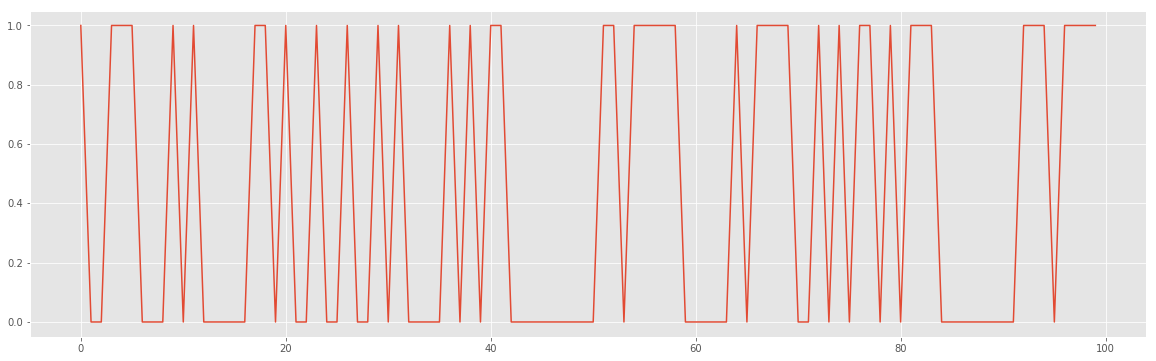

In [20]:
plt.figure(figsize=(20, 6))
plt.plot(p1_mean_rwds[-100:])

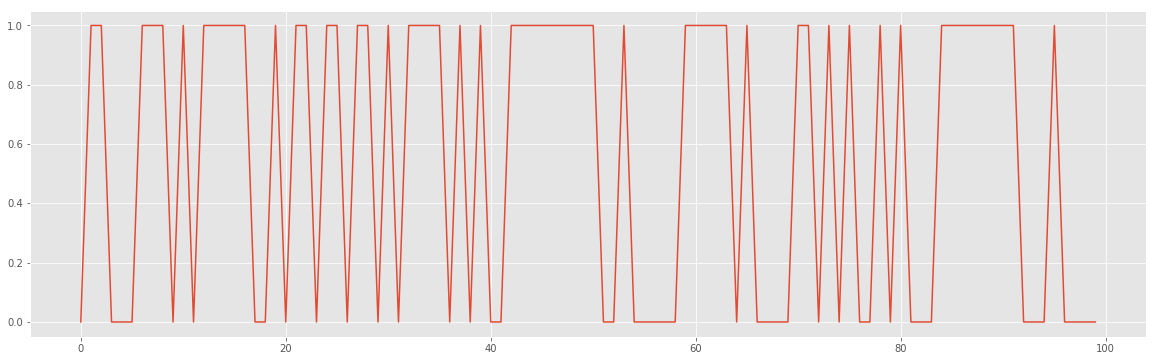

In [21]:
plt.figure(figsize=(20, 6))
plt.plot(p2_mean_rwds[-100:])

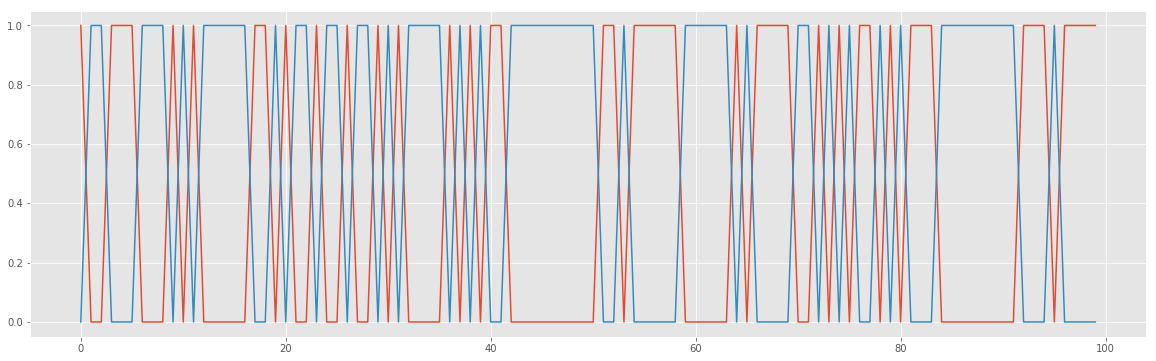

In [22]:
plt.figure(figsize=(20, 6))
plt.plot(p1_mean_rwds[-100:])
plt.plot(p2_mean_rwds[-100:])

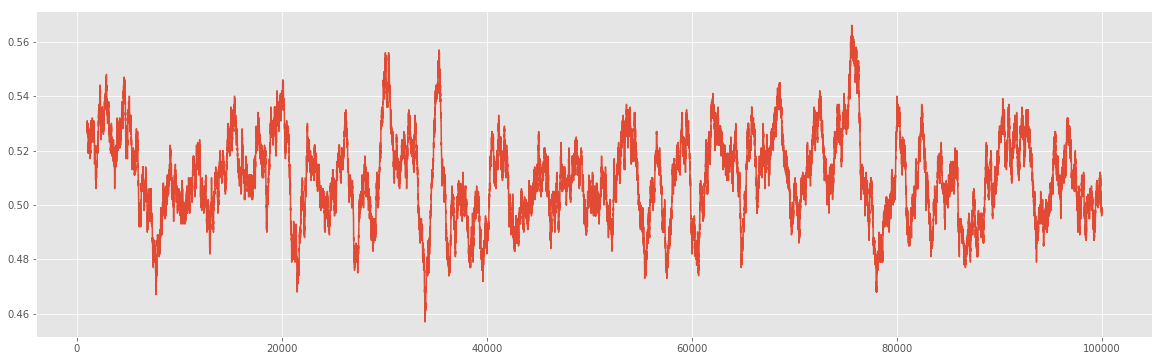

In [27]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(p1_mean_rwds).rolling(1000, min_periods=1000).mean())

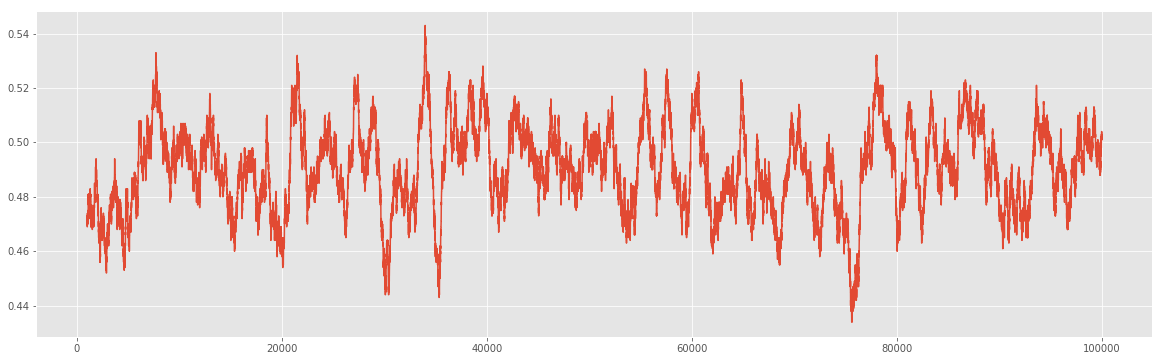

In [28]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(p2_mean_rwds).rolling(1000, min_periods=1000).mean())

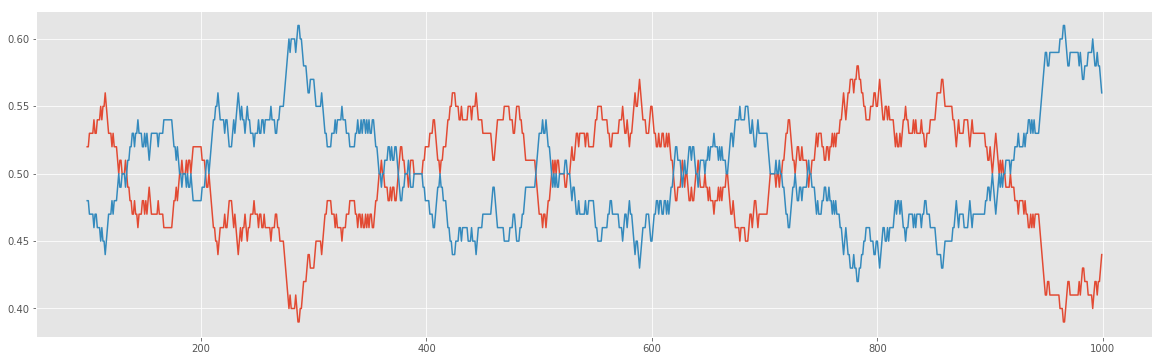

In [29]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(p1_mean_rwds[-1000:]).rolling(100, min_periods=100).mean())
plt.plot(pd.Series(p2_mean_rwds[-1000:]).rolling(100, min_periods=100).mean())